In [70]:
# Import the necessary packages to perform the data analysis

# packages to process and visualize the data
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# packages to improve visual description and analysis
from IPython.core import display as ICD
pd.set_option('display.max_columns', 100)
import os

## Research Question

**To what extent tax heavens and business friendly regulations attract companies from all over the world and contribute to the income inequality in the home countries?**

**What drives entities to go offshore and consequently how does that affect the country?**

In order to answer the above question, the following subquestion have to be answered:

**1)** Which are the jurisdictions in which entities found in Panama papers are registered?

**2)** What countries have the most entities register in the Panama papers?

**3)** What are the burocratic and economic causes pushing entities to go offshore?

**4)** How does the number of entities in a country which are mentioned in the Panama papers reflect with the income inequality within a country?

### Interpretation of the Panama Papers

As shown by the exploratory analysis, the entity document of the Panama Papers is a very interesting: it provides a macroscopic view of how many entities per countries are involved in settling companies offshore. The reasons behind making an offshore company are multiple: setting a company offshore is not a crime, but it is an indication that the business condition in the home country are not always favorable from a privacy point of view, from a bureaucratic point of view and from a tax point of view. In other words it is investigated whether the discrepancy between ease of business that exist between tax haven countries and non tax havens, can be a cause of high income inequality in non tax haven countries. The idea of investigating which of the top 2000 companies in the world are present in the Panama papers and estimate the capital lost was dropped because it is very hard to find the real name of the companies and link the two without doing a stakeholder analysis.

### Practical Objectives

The results that are going to be obtained at the end of the research will be the following:

Which are the jurisdictions in which entities found in Panama papers are registered?

- **Map the tax heavens jurisdiction in terms of the number of entities they have registered **

What countries have the most entities register in the Panama papers?

- **Map countries in the world according to how much they appear in the Panama Papers in terms of entities**

What are the burocratic and economic causes pushing entities to go offshore? How does the number of entities in a country which are mentioned in the Panama papers reflect with the social and income inequality within a country?

- **Investigate the role that the indicators 'Days to open a business', 'Tax rate', 'Time spent dealing with legal requirements', 'Ease of doing business coefficients' have in pushing entities and companies already to establish in countries which offer business friendly regulations**

- **Identify the group of countries whose entities' high presence in the Panama papers is linked to income inequality**

- **Show the evolution of income inequality and entities' presence in the Panama papers over time**

### Description of additional Dataset

In [71]:
folder='../data/'

The followings are the additional datasets used for the investigation taken in the World Bank Dataset:

- `API_SI.POV.GINI_DS2_en_csv_v2_10224868.csv`, is the GINI coefficient per country

- `API_IC.BUS.EASE.XQ_DS2_en_csv_v2_10226725.csv`, is the Ease of Business coefficient per country

- `API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10224782.csv`, is the GDP per country

- `API_NY.GDP.PCAP.CD_DS2_en_csv_v2_10224851.csv`, is the GDP per capita per country

- `API_IC.REG.DURS_DS2_en_csv_v2_10225592.csv`, is the time to start a business per country

- `API_IC.GOV.DURS.ZS_DS2_en_csv_v2_10230883.csv`, is the time spent by business in government regulation per country

- `API_GC.TAX.YPKG.RV.ZS_DS2_en_csv_v2_10227627.csv`, is the tax rate per country

The role of the indicators above in influencing entities and companies to have offshore holdings will be investigated

### Exploratory Analysis

After having examined the number of entities present in the papers according to the country, the role of the indicators highlighted above is investigated. In this notebook two indicators have been partially analysed to provide an example of the type of analysis that will be done.

In [74]:
df_edges_raw = pd.read_csv(folder + 'panama_papers.edges.csv')
df_address_raw = pd.read_csv(folder + 'panama_papers.nodes.address.csv')
df_entity_raw = pd.read_csv(folder + 'panama_papers_modified.nodes.entity.csv', encoding = "ISO-8859-1")
df_intermediary_raw = pd.read_csv(folder + 'panama_papers.nodes.intermediary.csv')
df_officier_raw = pd.read_csv(folder + 'panama_papers.nodes.officer.csv')

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_entity_raw.head()

In [75]:
country_count=pd.DataFrame(df_entity_raw['countries'].value_counts())

Firstly a dataframe with the country and the respective number of entities in the Panama Papers is made. This is used as a base to subsequentially add information regarding the indicators.

In [76]:
country_count=country_count.rename(columns={'countries': 'n_companies_offshore'})
country_count['Country Name']=country_count.index
country_count=country_count.reset_index(drop=True)

In [77]:
country_count.head()

,n_companies_offshore,Country Name
0,37911,"Hong Kong SAR, China"
1,37911,Switzerland
2,21658,Channel Islands
3,15811,Panama
4,10840,Luxembourg


In order to investigate the relationship between income inequality and number of entities in the Panama papers per country, the number of entities per country has to be weighted according to economical size: without doing so, big economies will automatically have a higher number of entities registered in the papers only because they are bigger. Hence GDP and GDP per capita are going to be used as weighting factor for the number of registered entities in papers, n: 

\begin{equation*}
n_{w}=\frac{n}{GDP_{indicator}}
\end{equation*}

In [129]:
df_gdp=pd.read_csv(folder+'API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10224782.csv', skiprows=[0,1,2,3])

In [130]:
df_countries_gdp=pd.DataFrame({'Country Name':df_gdp['Country Name'],'GDP':df_gdp.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})
# print(np.sum(df_countries_gdp['GDP'].isnull()))
# df_gdp=df_gdp[df_gdp['GDP'].notnull()]

In [131]:
df_countries_gdp[df_countries_gdp['GDP'].isnull()]

,Country Name,GDP
49,Curacao,NaN
108,Not classified,NaN
145,St. Martin (French part),NaN
170,New Caledonia,NaN
191,"Korea, Dem. People?s Rep.",NaN
197,French Polynesia,NaN


In [132]:
df_gdp_capita=pd.read_csv(folder+'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_10224851.csv', skiprows=[0,1,2,3])

In [133]:
df_countries_gdp_capita=pd.DataFrame({'Country Name':df_gdp_capita['Country Name'],'GDP':df_gdp_capita.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})
# print(np.sum(df_countries_gdp['GDP'].isnull()))
# df_gdp=df_gdp[df_gdp['GDP'].notnull()]

In [134]:
df_countries_gdp_capita[df_countries_gdp_capita['GDP'].isnull()]

,Country Name,GDP
49,Curacao,NaN
108,Not classified,NaN
145,St. Martin (French part),NaN
170,New Caledonia,NaN
191,"Korea, Dem. People?s Rep.",NaN
197,French Polynesia,NaN


In [125]:
# count in panama papers and gdp is merged in one dataframe
country_count_gdp=country_count.merge(df_countries_gdp, how='outer',left_on='Country Name', right_on='Country Name')

In [135]:
# count in panama papers and gdp per capita is merged in one dataframe
country_count_gdp=country_count_gdp.merge(df_countries_gdp_capita, how='outer',left_on='Country Name', right_on='Country Name')

In [136]:
country_count_gdp.head()

,n_companies_offshore,Country Name,GDP_x,GDP_y
0,37911.0,"Hong Kong SAR, China",2.420000e+11,34139.405171
1,37911.0,Switzerland,5.693333e+11,72018.654377
2,21658.0,Channel Islands,9.180788e+09,59422.543726
3,15811.0,Panama,3.405630e+10,9062.889846
4,10840.0,Luxembourg,5.192631e+10,100087.833141


In [138]:
country_count_gdp['Country Name'][country_count_gdp['GDP_y'].isna()]

16                        Taiwan
40                          Niue
80                       Curacao
151                 Cook Islands
200               Not classified
213     St. Martin (French part)
225                New Caledonia
233    Korea, Dem. People?s Rep.
238             French Polynesia
Name: Country Name, dtype: object

As highlighted initially, there is a chunck of entities/companies which are registered in Panama papers and which come already from countries with favorable business conditions. Hence it will be important to understand what are these favorable conditions. The year with most data regarding each indicator will be considered assuming that the change in each indicator in the last 10 years is irrelevant. In order to explore the role of each indicator, interactive plots are created to better investigate individually what are the conditions which push entities to go offshore.

#### Tax Rate

Chances of having lower tax rates already push companies to have holdings in tax havens. Do greater tax rates correspond with higher income inequality?

In [140]:
df_tax_weight=pd.read_csv(folder+'API_GC.TAX.YPKG.RV.ZS_DS2_en_csv_v2_10227627.csv', skiprows=[0,1,2,3])

In [141]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_tax_weight[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

Year with most data is 2010


In [142]:
df_countries_tax=pd.DataFrame({'Country Name':df_tax_weight['Country Name'],'Tax Rate':df_tax_weight.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})
print(np.sum(df_countries_tax['Tax Rate'].isnull()))
df_countries_tax=df_countries_tax[df_countries_tax['Tax Rate'].notnull()]

62


In [143]:
df_countries_tax.head()

,Country Name,Tax Rate
1,Afghanistan,3.718429
2,Angola,40.648405
3,Albania,14.046091
5,Arab World,22.879864
7,Argentina,14.509155


The distribution of the tax rate overall is found

/Users/gianlucamancini/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


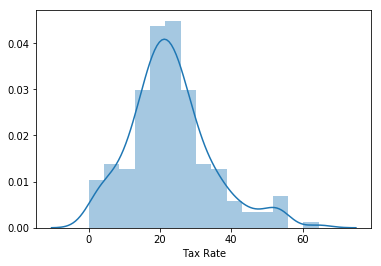

In [144]:
sns.distplot(df_countries_tax['Tax Rate'])

A dataset with tax rate and number of companies registered in the panama papers is made.

In [145]:
country_count_tax_rate=country_count_gdp.merge(df_countries_tax, how='outer',left_on='Country Name', right_on='Country Name')

In [147]:
country_count_tax_rate[country_count_tax_rate['GDP_y']>50000]

,n_companies_offshore,Country Name,GDP_x,GDP_y,Tax Rate
1,37911.0,Switzerland,5.693333e+11,72018.654377,20.860170
2,21658.0,Channel Islands,9.180788e+09,59422.543726,NaN
4,10840.0,Luxembourg,5.192631e+10,100087.833141,28.729217
9,4892.0,Isle of Man,5.216144e+09,65308.380697,NaN
14,3168.0,Monaco,5.301932e+09,148406.483360,NaN
17,2066.0,Liechtenstein,4.922173e+09,136708.283262,NaN
18,2039.0,Gibraltar,2.288000e+09,92843.000000,NaN
43,322.0,Ireland,2.464667e+11,54731.376007,37.941031
53,165.0,Bermuda,5.418704e+09,84080.952572,NaN
58,106.0,Cayman Islands,3.343516e+09,61454.453850,NaN


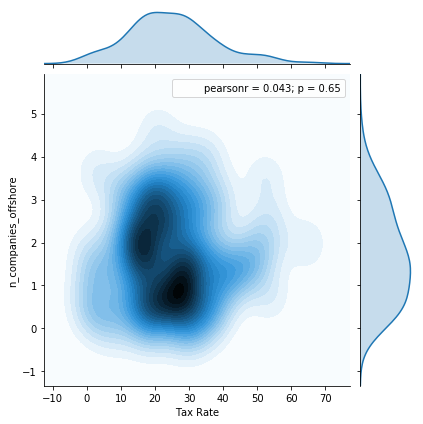

In [148]:
sns.jointplot(country_count_tax_rate['Tax Rate'],np.log10(country_count_tax_rate['n_companies_offshore']), kind="kdeplot", n_levels=30)

Below an interactive graph showing the relationship between the tax rate and the number of offshore entities is made to investigate a relationship between the two variables and look how each country behave.

In [ ]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

x = country_count_tax_rate['Tax Rate']
y = np.log10(country_count_tax_rate['n_companies_offshore'])
#radii = possibility to add radii as a measure of the economy size

source=ColumnDataSource(data=dict(
    x=list(country_count_tax_rate['Tax Rate']),
    y=list(np.log10(country_count_tax_rate['n_companies_offshore'])),
    country=list(country_count_tax_rate['Country Name']),
))

colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=[hover], title="Number of entities offshore and tax rate ")

p.title.text_color = "blue"
p.title.text_font = "helvetica"
p.title.text_font_style = "italic"

p.xaxis.axis_label='Tax Rate'
p.yaxis.axis_label='log_10(n_entities offshore)'

p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)

output_file("tax rate.html", title="Tax Rate plot")

show(p)

Graph of tax rate and presence in Panama Paper of small developped countries with high income per capita 

In [246]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

x = country_count_tax_rate['Tax Rate'][country_count_tax_rate['GDP_y'].apply(lambda x: x>30000) & country_count_tax_rate['GDP_x'].apply(lambda x: x<200*10e9)]
y = np.log10(country_count_tax_rate['n_companies_offshore'][country_count_tax_rate['GDP_y'].apply(lambda x: x>30000) & country_count_tax_rate['GDP_x'].apply(lambda x: x<200*10e9)])
#radii = possibility to add radii as a measure of the economy size

source=ColumnDataSource(data=dict(
    x=list(country_count_tax_rate['Tax Rate'][country_count_tax_rate['GDP_y'].apply(lambda x: x>30000) & country_count_tax_rate['GDP_x'].apply(lambda x: x<200*10e9)]),
    y=list(np.log10(country_count_tax_rate['n_companies_offshore'][country_count_tax_rate['GDP_y'].apply(lambda x: x>30000) & country_count_tax_rate['GDP_x'].apply(lambda x: x<200*10e9)])),
    country=list(country_count_tax_rate['Country Name'][country_count_tax_rate['GDP_y'].apply(lambda x: x>30000) & country_count_tax_rate['GDP_x'].apply(lambda x: x<200*10e9)]),
))

# colors = [
#     "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
# ]

hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=[hover], title="Number of entities offshore vs tax rate")

p.title.text_color = "blue"
p.title.text_font = "helvetica"
p.title.text_font_style = "italic"

p.xaxis.axis_label='Tax Rate'
p.yaxis.axis_label='log_10(n_entities offshore)'

p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)

output_file("taxratesmalldeveloppedcountries.html", title="taxratesmalldeveloppedcountries")

show(p)

Graph of the biggest economies

In [244]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

x = country_count_tax_rate['Tax Rate'][country_count_tax_rate['GDP_x'].apply(lambda x: x>200*10e9)]
y = np.log10(country_count_tax_rate['n_companies_offshore'][country_count_tax_rate['GDP_x'].apply(lambda x: x>200*10e9)]/country_count_tax_rate['GDP_x'][country_count_tax_rate['GDP_x'].apply(lambda x: x>200*10e9)])
#radii = possibility to add radii as a measure of the economy size

source=ColumnDataSource(data=dict(
    x=list(country_count_tax_rate['Tax Rate'][country_count_tax_rate['GDP_x'].apply(lambda x: x>200*10e9)]),
    y=list(np.log10(country_count_tax_rate['n_companies_offshore'][country_count_tax_rate['GDP_x'].apply(lambda x: x>200*10e9)]/country_count_tax_rate['GDP_x'][country_count_tax_rate['GDP_x'].apply(lambda x: x>200*10e9)])),
    country=list(country_count_tax_rate['Country Name'][country_count_tax_rate['GDP_x'].apply(lambda x: x>200*10e9)]),
))

# colors = [
#     "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
# ]

hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=[hover], title="Number of entities offshore vs tax rate")

p.title.text_color = "blue"
p.title.text_font = "helvetica"
p.title.text_font_style = "italic"

p.xaxis.axis_label='Tax Rate'
p.yaxis.axis_label='log_10(n_entities offshore)'

p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)

output_file("taxrateg8.html", title="taxrateg8")

show(p)

Graph of tax rate of all developped countries with legend of GDP per capita and GDP

In [245]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, LogColorMapper, LogTicker, ColorBar

# for colors
c = country_count_tax_rate['GDP_y'][country_count_tax_rate['GDP_y']>15000]
c[c.isna()]=0



# colors = [
#     "#%02x%02x%02x" % (int(r), 25, 50) for r in x*10e-7
# ]

color_mapper = LogColorMapper(palette="Colorblind8", low=min(c),\
                              high=max(c))

source=ColumnDataSource(data=dict(
    x=list(country_count_tax_rate['Tax Rate'][country_count_tax_rate['GDP_y']>15000]),
    y=list(np.log10(country_count_tax_rate['n_companies_offshore'][country_count_tax_rate['GDP_y']>15000]/country_count_tax_rate['GDP_x'][country_count_tax_rate['GDP_y']>15000])),
    country=list(country_count_tax_rate['Country Name'][country_count_tax_rate['GDP_y']>15000]),
    radii=list(country_count_tax_rate['GDP_x'][country_count_tax_rate['GDP_y']>15000]*10e-13),
    c=list(c),
))



hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=[hover], title="Number of entities offshore vs tax rate")

p.title.text_color = "blue"
p.title.text_font = "helvetica"
p.title.text_font_style = "italic"

p.xaxis.axis_label='Tax Rate'
p.yaxis.axis_label='log_10(n_entities offshore)'

p.scatter(x='x', y='y', radius='radii', source=source, color={'field': 'c', 'transform': color_mapper}, alpha=0.5)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

# add the color bar
p.add_layout(color_bar, 'right')

output_file("taxrate_developped.html", title="taxrate_developped")

show(p)

### Days to open a  business

Chances of having better business already push companies to have holdings in tax havens or semi tax haven countries such as Singapore, Switzerland or Hong Kong. How much weight does this coefficient have?

In [232]:
df_ease_business=pd.read_csv(folder+'API_IC.REG.DURS_DS2_en_csv_v2_10225592.csv', skiprows=[0,1,2,3])

In [233]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_ease_business[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

Year with most data is 2015


In [234]:
#df_countries_ease_business=pd.DataFrame({'Country Name':df_ease_business['Country Name'][df_ease_business['2015'].notnull()],'days_open_business':df_ease_business['2015'][df_ease_business['2013'].notnull()]})
df_countries_ease_business=pd.DataFrame({'Country Name':df_ease_business['Country Name'],'days_open_business':df_ease_business.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})
df_countries_ease_business=df_countries_ease_business[df_countries_ease_business['days_open_business'].notnull()]

In [235]:
df_countries_ease_business.head()

,Country Name,days_open_business
1,Afghanistan,8.071429
2,Angola,64.714286
3,Albania,15.357143
5,Arab World,26.151124
6,United Arab Emirates,13.350000


In [236]:
country_count_ease_business=country_count_gdp.merge(df_countries_ease_business, how='inner',left_on='Country Name', right_on='Country Name')

The distribution of the ease of business coefficients is found

In [ ]:
country_count_ease_business['days_open_business'].plot(kind='kde')

In [ ]:
country_count_ease_business.head()

A dataset with ease of business conditions and number of companies registered in the panama papers is made.

In [ ]:
sns.jointplot(country_count_ease_business['days_open_business'],np.log10(country_count_ease_business['n_companies_offshore']))

Graph of days to open business and presence in Panama Paper of small developped countries with high income per capita 

In [237]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

x = country_count_ease_business['days_open_business'][country_count_ease_business['GDP_y'].apply(lambda x: x>30000) & country_count_ease_business['GDP_x'].apply(lambda x: x<200*10e9)]
y = np.log10(country_count_ease_business['n_companies_offshore'][country_count_ease_business['GDP_y'].apply(lambda x: x>30000) & country_count_ease_business['GDP_x'].apply(lambda x: x<200*10e9)])
#radii = possibility to add radii as a measure of the economy size

source=ColumnDataSource(data=dict(
    x=list(country_count_ease_business['days_open_business'][country_count_ease_business['GDP_y'].apply(lambda x: x>30000) & country_count_ease_business['GDP_x'].apply(lambda x: x<200*10e9)]),
    y=list(np.log10(country_count_ease_business['n_companies_offshore'][country_count_ease_business['GDP_y'].apply(lambda x: x>30000) & country_count_ease_business['GDP_x'].apply(lambda x: x<200*10e9)])),
    country=list(country_count_ease_business['Country Name'][country_count_ease_business['GDP_y'].apply(lambda x: x>30000) & country_count_ease_business['GDP_x'].apply(lambda x: x<200*10e9)]),
))

# colors = [
#     "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
# ]

hover= HoverTool(tooltips = [("Country", "@country"),("(Days open business, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=[hover], title="Number of entities offshore vs days to open a business")

p.title.text_color = "blue"
p.title.text_font = "helvetica"
p.title.text_font_style = "italic"

p.xaxis.axis_label='Days to open a business'
p.yaxis.axis_label='log_10(n_entities offshore)'

p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)

output_file("daysopnebusinesssmalldeveloppedcountries.html", title="daysopnebusinesssmalldeveloppedcountries")

show(p)

Graph of the biggest economies

In [238]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

x = country_count_ease_business['days_open_business'][country_count_ease_business['GDP_x'].apply(lambda x: x>200*10e9)]
y = np.log10(country_count_ease_business['n_companies_offshore'][country_count_ease_business['GDP_x'].apply(lambda x: x>200*10e9)])
#radii = possibility to add radii as a measure of the economy size

source=ColumnDataSource(data=dict(
    x=list(country_count_ease_business['days_open_business'][country_count_ease_business['GDP_x'].apply(lambda x: x>200*10e9)]),
    y=list(np.log10(country_count_ease_business['n_companies_offshore'][country_count_ease_business['GDP_x'].apply(lambda x: x>200*10e9)])),
    country=list(country_count_ease_business['Country Name'][country_count_ease_business['GDP_x'].apply(lambda x: x>200*10e9)]),
))

# colors = [
#     "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
# ]

hover= HoverTool(tooltips = [("Country", "@country"),("(Days to open business, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=[hover], title="Number of entities offshore vs days to open business")

p.title.text_color = "blue"
p.title.text_font = "helvetica"
p.title.text_font_style = "italic"

p.xaxis.axis_label='Days open a business'
p.yaxis.axis_label='log_10(n_entities offshore)'

p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)

output_file("daysopenbusinessg8.html", title="daysopenbusinessg8")

show(p)

Graph of days to open business of all developped countries with legend of GDP per capita and GDP

In [239]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, LogColorMapper, LogTicker, ColorBar

# for colors
c = country_count_ease_business['GDP_y'][country_count_ease_business['GDP_y']>15000]
c[c.isna()]=0



# colors = [
#     "#%02x%02x%02x" % (int(r), 25, 50) for r in x*10e-7
# ]

color_mapper = LogColorMapper(palette="Colorblind8", low=min(c),\
                              high=max(c))

source=ColumnDataSource(data=dict(
    x=list(country_count_ease_business['days_open_business'][country_count_ease_business['GDP_y']>15000]),
    y=list(np.log10(country_count_ease_business['n_companies_offshore'][country_count_ease_business['GDP_y']>15000])),
    country=list(country_count_ease_business['Country Name'][country_count_ease_business['GDP_y']>15000]),
    radii=list(country_count_ease_business['GDP_x'][country_count_ease_business['GDP_y']>15000]*10e-13),
    c=list(c),
))



hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=[hover], title="Number of entities offshore vs days to open a business")

p.title.text_color = "blue"
p.title.text_font = "helvetica"
p.title.text_font_style = "italic"

p.xaxis.axis_label='Days open a business'
p.yaxis.axis_label='log_10(n_entities offshore)'

p.scatter(x='x', y='y', radius='radii', source=source, color={'field': 'c', 'transform': color_mapper}, alpha=0.5)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

# add the color bar
p.add_layout(color_bar, 'right')

output_file("daysopenbusinessdevelopped.html", title="daysopenbusinessdevelopped")

show(p)

### Ease of Business Coefficient

In [31]:
df_ease_business_coefficient=pd.read_csv(folder+'API_IC.BUS.EASE.XQ_DS2_en_csv_v2_10226725.csv', skiprows=[0,1,2,3])

In [32]:
df_ease_business_coefficient

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.0,NaN
2,Angola,AGO,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0,NaN
3,Albania,ALB,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN
4,Andorra,AND,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Arab World,ARB,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,United Arab Emirates,ARE,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
7,Argentina,ARG,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,NaN
8,Armenia,ARM,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN
9,American Samoa,ASM,Ease of doing business index (1=most business-...,IC.BUS.EASE.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_ease_business_coefficient[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

Year with most data is 2017


In [34]:
df_ease_business_coefficient=pd.DataFrame({'Country Name':df_ease_business_coefficient['Country Name'],'business_coefficient':df_ease_business_coefficient.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})
df_ease_business_coefficient=df_ease_business_coefficient[df_ease_business_coefficient['business_coefficient'].notnull()]

In [35]:
df_ease_business_coefficient.head()

,Country Name,business_coefficient
1,Afghanistan,183.0
2,Angola,175.0
3,Albania,65.0
6,United Arab Emirates,21.0
7,Argentina,117.0


In [ ]:
country_count_ease_business_coefficient=country_count_gdp.merge(df_ease_business_coefficient, how='inner',left_on='Country Name', right_on='Country Name')

The distribution of the ease of business coefficients is found

In [ ]:
country_count_ease_business_coefficient['business_coefficient'].plot(kind='kde')

In [ ]:
country_count_ease_business_coefficient.head()

A dataset with ease of business conditions and number of companies registered in the panama papers is made.

In [ ]:
sns.jointplot(country_count_ease_business_coefficient['business_coefficient'],np.log10(country_count_ease_business_coefficient['n_companies_offshore']))

In [ ]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

x = country_count_ease_business_coefficient['business_coefficient'][country_count_ease_business_coefficient['GDP_y']>50000]
y = np.log10(country_count_ease_business_coefficient['n_companies_offshore'][country_count_ease_business_coefficient['GDP_y']>50000])
#radii = possibility to add radii as a measure of the economy size

source=ColumnDataSource(data=dict(
    x=list(country_count_ease_business_coefficient['business_coefficient'][country_count_ease_business_coefficient['GDP_y']>50000]),
    y=list(np.log10(country_count_ease_business_coefficient['n_companies_offshore'][country_count_ease_business_coefficient['GDP_y']>50000])),
    country=list(country_count_ease_business_coefficient['Country Name'][country_count_ease_business_coefficient['GDP_y']>50000]),
))

colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

hover= HoverTool(tooltips = [("Country", "@country"),("(days to open business, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"


p = figure(tools=[hover],title="Number of entities offshore vs business coefficient")

p.scatter(x='x', y='y', radius=0.8, source=source, fill_alpha=0.6)

p.title.text_color = "blue"
p.title.text_font = "helvetica"
p.title.text_font_style = "italic"

p.xaxis.axis_label='business coefficient'
p.yaxis.axis_label='log_10(n_entities offshore)'

output_file("ease_business.html", title="ease_business")

show(p)

### Time spent in regulations

In [ ]:
df_time_regulation=pd.read_csv(path+'API_IC.GOV.DURS.ZS_DS2_en_csv_v2_10230883.csv', skiprows=[0,1,2,3])

In [ ]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_time_regulation[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

In [ ]:
df_time_regulation=pd.DataFrame({'Country Name':df_time_regulation['Country Name'][df_time_regulation['2009'].notnull()],'time_regulation':df_time_regulation['2009'][df_time_regulation['2009'].notnull()]})

In [ ]:
df_time_regulation.head()

In [ ]:
country_count_ease_regulation_time=country_count_gdp.merge(df_time_regulation, how='inner',left_on='Country Name', right_on='Country Name')

The distribution of the ease of business coefficients is found

In [ ]:
country_count_ease_regulation_time['time_regulation'].plot(kind='kde')

In [ ]:
country_count_ease_regulation_time[~country_count_ease_regulation_time.isna()]

A dataset with ease of business conditions and number of companies registered in the panama papers is made.

In [ ]:
sns.jointplot(country_count_ease_regulation_time['time_regulation'],np.log10(country_count_ease_regulation_time['n_companies_offshore']))

In [ ]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

x = country_count_ease_regulation_time['time_regulation']
y = np.log10(country_count_ease_regulation_time['n_companies_offshore'])
#radii = possibility to add radii as a measure of the economy size

source=ColumnDataSource(data=dict(
    x=list(country_count_ease_regulation_time['time_regulation']),
    y=list(np.log10(country_count_ease_regulation_time['n_companies_offshore'])),
    country=list(country_count_ease_regulation_time['Country Name']),
))

colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

hover= HoverTool(tooltips = [("Country", "@country"),("(days to open business, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"


p = figure(tools=[hover],title="Number of entities offshore vs time spent with regulations")

p.scatter(x='x', y='y', radius=0.5, source=source, fill_alpha=0.6)

p.title.text_color = "blue"
p.title.text_font = "helvetica"
p.title.text_font_style = "italic"

p.xaxis.axis_label='time spent in regulations'
p.yaxis.axis_label='log_10(n_entities offshore)'

output_file("time_regulation.html", title="time_regulation")

show(p)

#### Example of Gini Coefficient Analysis

Finally an example of how the above mentioned coefficients will be used as weighting factors to investigate income inequality is given for tax rate.

In [ ]:
df_gini=pd.read_csv(path+'API_SI.POV.GINI_DS2_en_csv_v2_10224868.csv', skiprows=[0,1,2,3])

In [ ]:
df_gini.head()

In [ ]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_gini[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

In [ ]:
df_countries_gini=pd.DataFrame({'Country Name':df_gini['Country Name'][df_gini['2010'].notnull()],'Gini Coefficient':df_gini['2010'][df_gini['2010'].notnull()]})

In [ ]:
df_countries_gini.head()

In [ ]:
country_count_gini=country_count_gdp.merge(df_countries_gini, how='inner',left_on='Country Name', right_on='Country Name')

In [ ]:
country_count_gini=country_count_gini.merge(df_countries_tax, how='inner',left_on='Country Name', right_on='Country Name')

In [ ]:
country_count_gini.head()

The graph below shows that by taking account of multiple factors which influence a business to have an offshore holding and investigate the relationship with income inequality an interesting result arises. There seems to be a positive relationship between income inequality and presence in the panama papers. This suggests that even if entities move their capitals/businesses offshore without the intention of evading taxes, the discrepancy between the business conditions with their own home country can correlate with high income inequality. This is the case of some countris in Latin America such as Colombia, Uruguay, Ecuador, Costa Rica and Paraguay.

In [ ]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

x = country_count_gini['Gini Coefficient']
y = np.log10(country_count_gini['n_companies_offshore']*country_count_gini['Tax Rate']/country_count_gini['GDP_y'])

# radii = country_count_gini['Gini Coefficient']
# radii=list(country_count_gini['Gini Coefficient']*0.05),

source=ColumnDataSource(data=dict(
    x=list(country_count_gini['Gini Coefficient']),
    y=list(np.log10(country_count_gini['n_companies_offshore']*country_count_gini['Tax Rate']/country_count_gini['GDP_y'])),
    country=list(country_count_gini['Country Name']),
))

colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

hover= HoverTool(tooltips = [("Country", "@country"),("(Gini, Logfrequency)", "($x, $y)")])

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"


p = figure(tools=[hover])

p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)

output_file("gini.html", title="Gini Coefficient plot")

show(p)